<a href="https://colab.research.google.com/github/deeplylearned/cs6140/blob/main/OptimizeBooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from itertools import zip_longest

import tensorflow as tf
# tf.enable_eager_execution()

In [ ]:
def beale(x, y):
  return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

def booth(x, y):
  return (x+2*y-7)**2+ (2*x+y-5)**2

def rosenbrock(x, y):
  return (1-x)**2+100(y-x**2)**2

In [ ]:
minima = np.array([1., 3.])
minima_ = minima.reshape(-1, 1)
print("minima (1x2 row vector shape): {}".format(minima))
print("minima (2x1 column vector shape):")
print(minima_)

minima (1x2 row vector shape): [1. 3.]
minima (2x1 column vector shape):
[[1.]
 [3.]]


In [ ]:
sgd = tf.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')
momentum = tf.optimizers.SGD(learning_rate=0.01, momentum=0.7, nesterov=False, name='SGD')
nesterov = tf.optimizers.SGD(learning_rate=0.01, momentum=0.7, nesterov=True, name='SGD')

# adagrad = tf.train.AdagradOptimizer(0.1)
# rmsprop = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.9, epsilon=1e-10)
# adam = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8)

optimizers = [sgd, momentum, nesterov]
opt_names = ['sgd', 'momentum', 'nesterov']

In [ ]:
all_pathes = []
for opt, name in zip(optimizers, opt_names):
  x_init = 4.0
  x = tf.compat.v1.get_variable('x', dtype=tf.float32, initializer=tf.constant(x_init))
  y_init = 1.6
  y = tf.compat.v1.get_variable('y', dtype=tf.float32, initializer=tf.constant(y_init))

  print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(0, booth(x, y).numpy(), x.numpy(), y.numpy()))
  x_history = []
  y_history = []
  z_prev = 0.0
  max_steps = 100
  for step in range(max_steps):
    with tf.GradientTape() as g:
      #g.watch([x, y])
      z = booth(x, y)
    x_history.append(x.numpy())
    y_history.append(y.numpy())
    dz_dx, dz_dy = g.gradient(z, [x, y])
    opt.apply_gradients(zip([dz_dx, dz_dy], [x, y]))

    if (step+1) % 100 == 0:
      print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}  dx: {:.5f}  dy: {:.5f}".format(step+1, booth(x, y).numpy(), x.numpy(), y.numpy(), dz_dx.numpy(), dz_dy.numpy()))
      
    if np.abs(z_prev - z.numpy()) < 1e-6:
      break
    z_prev = z.numpy()
  print("{} training done!".format(name))
  print("  steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(step+1, booth(x, y).numpy(), x.numpy(), y.numpy()))
      
  x_history = np.array(x_history)
  y_history = np.array(y_history)
  path = np.concatenate((np.expand_dims(x_history, 1), np.expand_dims(y_history, 1)), axis=1).T
  all_pathes.append(path)

steps: 0  z: 21.200003  x: 4.00000  y: 1.60000
steps: 100  z: 0.170251  x: 1.29176  y: 2.70824  dx: 0.59543  dy: -0.59544
sgd training done!
  steps: 100  z: 0.170251  x: 1.29176  y: 2.70824
steps: 0  z: 21.200003  x: 4.00000  y: 1.60000
momentum training done!
  steps: 87  z: 0.000004  x: 1.00137  y: 2.99863
steps: 0  z: 21.200003  x: 4.00000  y: 1.60000
nesterov training done!
  steps: 92  z: 0.000005  x: 1.00154  y: 2.99846


In [ ]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([booth(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

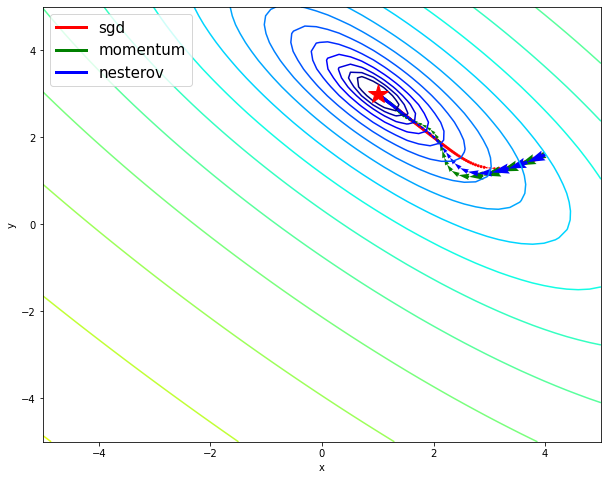

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)
colors = ['red', 'green', 'blue']
for name, path, color in zip(opt_names, all_pathes, colors):
  ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
            scale_units='xy', angles='xy', scale=1, color=color, lw=3)
  ax.plot([], [], color=color, label=name, lw=3)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

ax.legend(loc='upper left', prop={'size': 15})

plt.savefig('allplot.png', dpi=150, quality=100)
plt.show()

In [ ]:
class TrajectoryAnimation(animation.FuncAnimation):
  def __init__(self, *paths, labels=[], colors=[], fig=None, ax=None, frames=None, 
               interval=60, repeat_delay=5, blit=True, **kwargs):
    if fig is None:
      if ax is None:
        fig, ax = plt.subplots()
      else:
        fig = ax.get_figure()
    else:
      if ax is None:
        ax = fig.gca()

    self.fig = fig
    self.ax = ax

    self.paths = paths

    if frames is None:
      frames = max(path.shape[1] for path in paths)

    self.lines = [ax.plot([], [], label=label, color=color, lw=3)[0] 
                  for _, label, color in zip_longest(paths, labels, colors)]
    self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                   for line in self.lines]

    super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                              frames=frames, interval=interval, blit=blit,
                                              repeat_delay=repeat_delay, **kwargs)

  def init_anim(self):
    for line, point in zip(self.lines, self.points):
      line.set_data([], [])
      point.set_data([], [])
    return self.lines + self.points

  def animate(self, i):
    for line, point, path in zip(self.lines, self.points, self.paths):
      line.set_data(*path[::,:i])
      point.set_data(*path[::,i-1:i])
    return self.lines + self.points

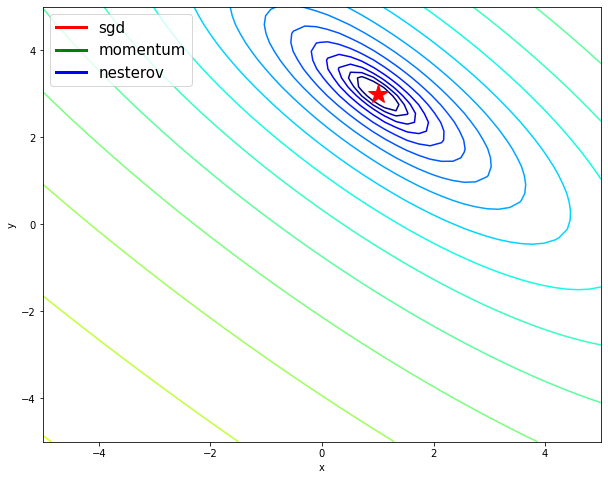

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

path_animation = TrajectoryAnimation(*all_pathes, labels=opt_names, colors=colors, ax=ax)

ax.legend(loc='upper left', prop={'size': 15})

In [ ]:
HTML(path_animation.to_html5_video())